# Week 8 Midterm project

First let's load some important libraries that will help us through this notebook, to make the data preparation, data cleaning, the exaploratory data analysis, model selection and parameter tuning

First the basic libraries for numerical processing

In [1]:
import numpy as np
import pandas as pd

Then some libraries for make some plots

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

The following libraries are the proposed models

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

This ones helps to preproced the data to the models

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

Finally the following libraries will helps us with the metrics

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

The following libraries are useful for times and processing

In [6]:
from tqdm.auto import tqdm

## 1.- Machine predictive maintenance classification dataset

The data is taken from Kaggle, but can be found under the following GitHub link

In [7]:
data = 'https://raw.githubusercontent.com/FranciscoOrtizTena/ML_Zoomcamp/main/8_week/predictive_maintenance.csv'

In [8]:
!wget $data

--2022-10-26 17:57:18--  https://raw.githubusercontent.com/FranciscoOrtizTena/ML_Zoomcamp/main/8_week/predictive_maintenance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 531013 (519K) [text/plain]
Saving to: 'predictive_maintenance.csv.1'

predictive_maintena 100%[===================>] 518.57K  --.-KB/s    in 0.1s    

2022-10-26 17:57:19 (3.69 MB/s) - 'predictive_maintenance.csv.1' saved [531013/531013]



In [9]:
!head predictive_maintenance.csv

In [10]:
df = pd.read_csv(data)

In [11]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [12]:
df.shape

(10000, 10)

## 2.- Data preparation and data cleaning

First let's standardize the columns without spaces and lowercase

In [13]:
df.columns = df.columns.str.lower().str.replace(' ','_')

Now let's check for the data type in each column 

In [14]:
df.dtypes

udi                          int64
product_id                  object
type                        object
air_temperature_[k]        float64
process_temperature_[k]    float64
rotational_speed_[rpm]       int64
torque_[nm]                float64
tool_wear_[min]              int64
target                       int64
failure_type                object
dtype: object

Since the columns udi and product_id does not apport to much information to the machine let's drop this columns

In [15]:
df = df.drop(['udi', 'product_id'], axis=1)

In [16]:
df.head()

,type,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],target,failure_type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


Therefor, we have just one categorical feature, which is type, and five numerical features, which are air_temperature_[k], process_temperature_[k], rotational_speed_[rpm], torque_[nm], tool_wear_[min]

In [17]:
categorical_columns = ['type']

In [18]:
numerical_columns = ['air_temperature_[k]', 'process_temperature_[k]', 
                     'rotational_speed_[rpm]', 'torque_[nm]', 'tool_wear_[min]']

This dataset has two target columns which are target, with a binary data type, 0  for No Failue and 1 for Failure, and failure type which describes what type of failure the machine had, lets clean the column of failure_type

In [19]:
df.failure_type = df.failure_type.str.lower().str.replace(' ','_')

In [20]:
df.head()

,type,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],target,failure_type
0,M,298.1,308.6,1551,42.8,0,0,no_failure
1,L,298.2,308.7,1408,46.3,3,0,no_failure
2,L,298.1,308.5,1498,49.4,5,0,no_failure
3,L,298.2,308.6,1433,39.5,7,0,no_failure
4,L,298.2,308.7,1408,40.0,9,0,no_failure


## 3.- Exploratory data analysis (EDA)

For the categorical values let's look at which values can take

In [21]:
df.type.value_counts()

L    6000
M    2997
H    1003
Name: type, dtype: int64

In [22]:
df.type.value_counts().isnull().sum()

0

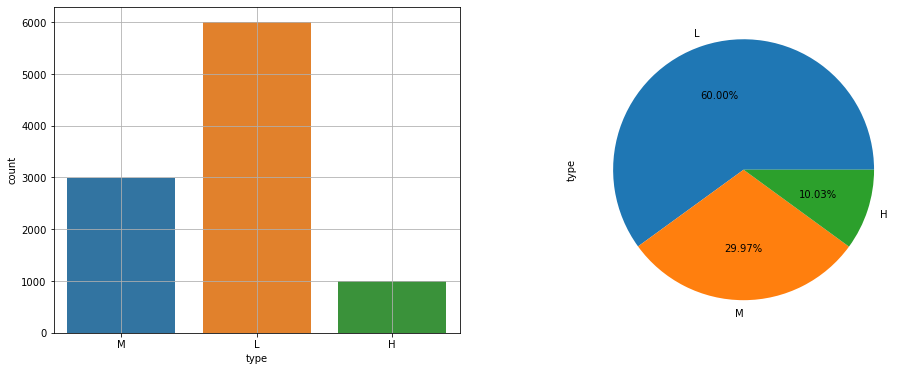

In [23]:
ax = plt.figure(figsize=(16,6))
ax = plt.subplot(1, 2, 1)
ax = sns.countplot(x='type', data=df)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
ax = df['type'].value_counts().plot.pie(autopct='%1.2f%%')
plt.show()

So the dataset has a 60% of Large equipments, 29.97% of medium equipments and only 10.03% of small equipments

Now for the numerical values let's make some exploratory data analysis. First let's check the describe method to check if there are some strange or missing values

In [24]:
df.describe()

,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


There are no missing values or some outliers.

Let's make some histograms for the air temperature, process temperature, rotational speed, torque, tool wear and target

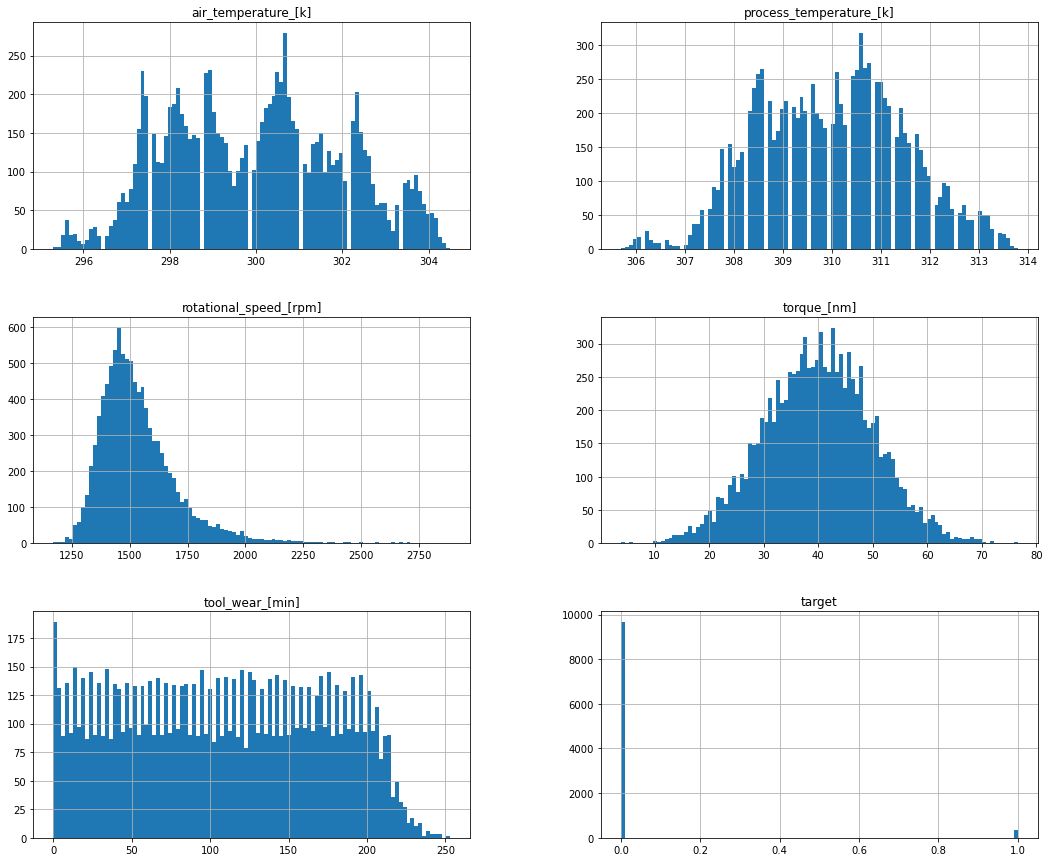

In [25]:
df.hist(bins=100, figsize=(18,15))
plt.show()

Now let's check for the correlation matrix among the features

It seem that the torque is the most important feature regarding a failure, let's make the plots

In [26]:
from pandas.plotting import scatter_matrix

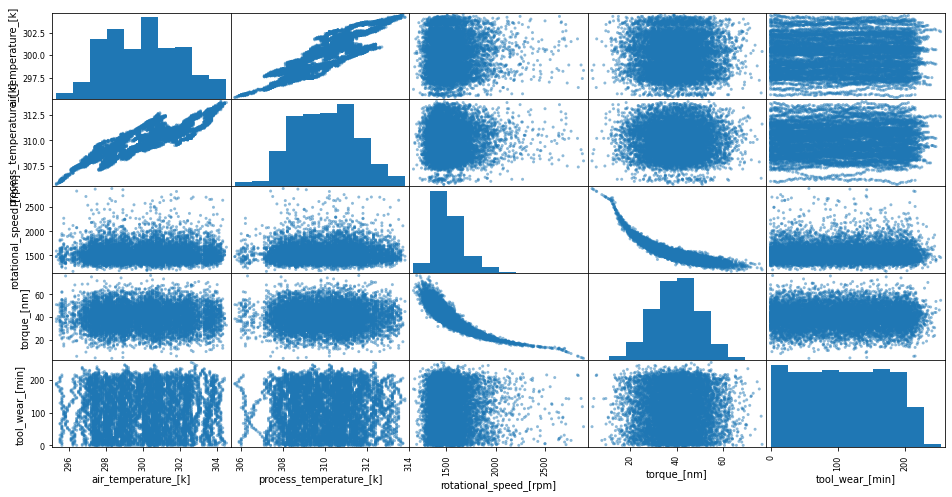

In [27]:
scatter_matrix(df[numerical_columns], figsize=(16,8))
plt.show()

The first big correlation among the features is the air_temperature with process_temperature, this is something expected as high air temperature the process temperature is expected to raise, and also for the second one which is the torque with the rotational_speed, let's check if the failure can be indetified at some space between this correlations.

For the air_temperature vs process_temperature

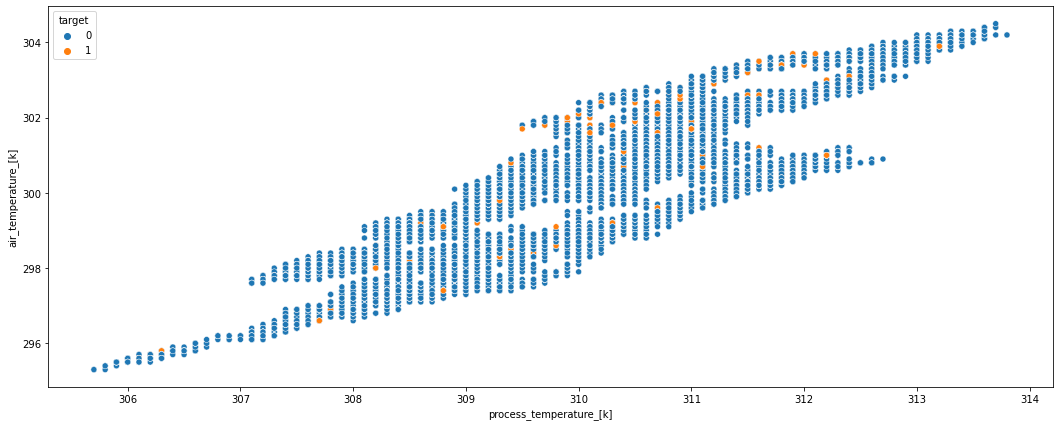

In [28]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=df['process_temperature_[k]'], y=df['air_temperature_[k]'], 
                hue=df['target'], palette='tab10')
plt.show()

For this correlation there is no clue of failure, now let's move into the second one

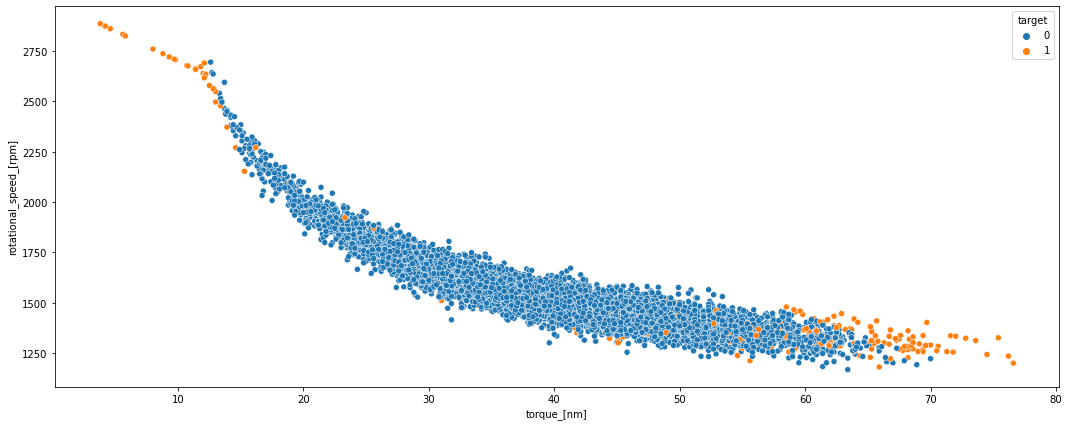

In [29]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=df['torque_[nm]'], y=df['rotational_speed_[rpm]'], 
                hue=df['target'], palette='tab10')
plt.show()

For this correlation it can be seen that if the torque is low and the rotational speed is high or if the torque is high with a rotational speed low, then is propense to a failure in the machine

Let's compare it with the type of the machine, first for the torque:

<Figure size 1152x432 with 0 Axes>

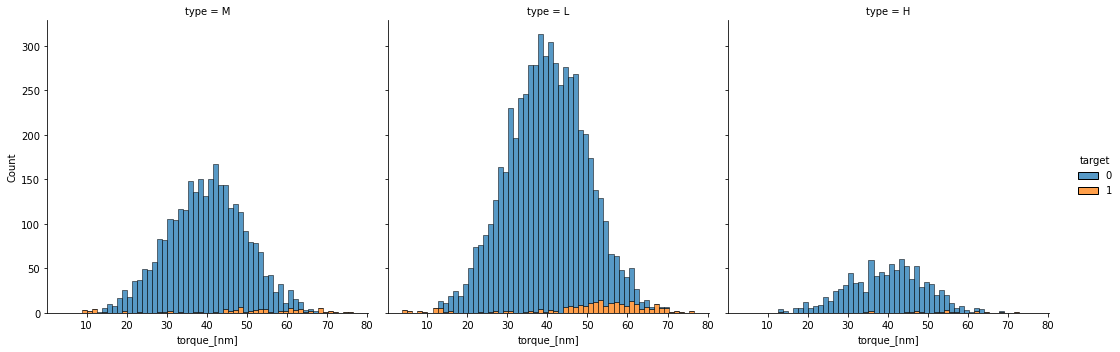

In [30]:
plt.figure(figsize=(16,6))
sns.displot(data=df, x=df['torque_[nm]'], col=df['type'], 
                 hue='target', multiple='stack')
plt.show()

Now for the rotational_speed

<Figure size 1152x432 with 0 Axes>

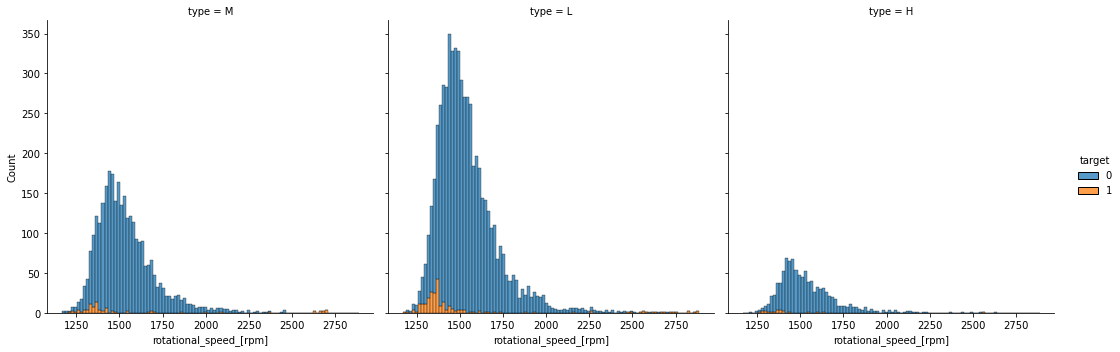

In [31]:
plt.figure(figsize=(16,6))
sns.displot(data=df, x=df['rotational_speed_[rpm]'], col=df['type'], 
                 hue='target', multiple='stack')
plt.show()

This bear out that with high torque and low rotational speed the machine is propense to fail.

Let's make the same graph of rotational_speed vs torque but for each type of machine

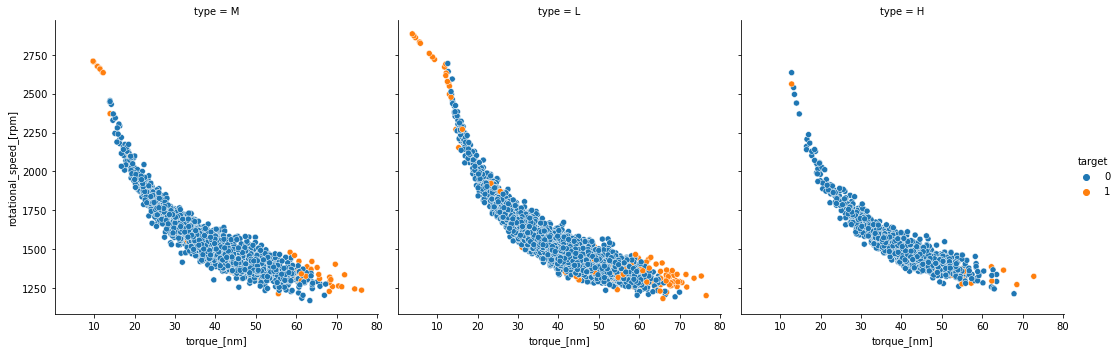

In [32]:
sns.relplot(data=df, x=df['torque_[nm]'], y=df['rotational_speed_[rpm]'], 
            hue=df['target'], col=df['type'])

Well this is a big discovery, if a machine is type "L" with high torque and low rotational speed the the machine is propense to fail, this can also be true for machines type "M"

## 4.- Model selection process and parameter tuning 

For this classification problem, the logistic regression, decision tree, random forest and XGBoost are proposed as models to predict if the machine is propense to fail or not.

### 4.1.- Setting up the validation framework

First let's create the train/validation/test sets, I will use a random_state=2 to reproduce the results

In [33]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=2)

In [34]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=2)

In [35]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Since the target value, Failure or not Failure is imbalance let's check if this sets mantain the proportion, first let's check for the total data

In [36]:
df.target.sum()/len(df)*100

3.39

Now for the train / validation / test sets

In [37]:
print('Proportion of train: ', round(df_train.target.sum()/len(df_train)*100, 2), 
      'validation: ', round(df_val.target.sum()/len(df_val)*100, 2),
      'test: ', round(df_test.target.sum()/len(df_test)*100, 2))

Proportion of train:  3.37 validation:  3.2 test:  3.65


Finally let's pass the prediction values and drop it from the dataframes

In [38]:
y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

del df_train['target']
del df_train['failure_type']
del df_val['target']
del df_val['failure_type']
del df_test['target']
del df_test['failure_type']

### 4.2.- Preprocessing

First we are going to make a one-hot encode for the features, especially the type of the machine

In [39]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

### 4.3.- Logistic Regression

Now let's train a logistic regression model

In [40]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

Now making the predictions

In [41]:
y_pred = lr.predict_proba(X_val)[:,1]
y_pred_hard = lr.predict(X_val)

Finally lets calculate some metrics. First the confusion matrix

In [42]:
confusion_matrix(y_val, y_pred_hard)

array([[1932,    4],
       [  51,   13]])

Now calculating the precision and recall

In [43]:
precision_score(y_val, y_pred_hard)

0.7647058823529411

This tell us that the model does not look really well since it claims an machine failure, it is correct only 76.47% of the time.

And now for recall

In [44]:
recall_score(y_val, y_pred_hard)

0.203125

More over it only detects 20.31% of the failures, so its not a good model, let's evaluate the roc_auc_score

In [45]:
lr_auc = roc_auc_score(y_val, y_pred)
lr_auc

0.8893013946280991

Now let's compute the ROC curve

In [46]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

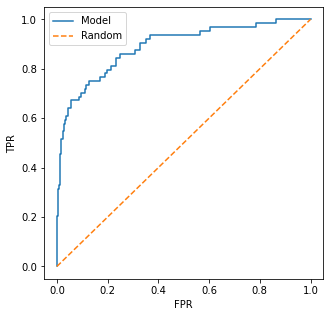

In [47]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

And finally the roc_auc_score

In [48]:
lr_auc = round(roc_auc_score(y_val, y_pred) * 100, 2)
lr_auc

88.93

Which is not quite bad but can be improved

### 4.3.1.- Paramater tuning for Logistic Regression

One paramater that can be tune in the LogisticRegression is the C parameter which is a regularization. Lets train different models with different values of C, and also lets train the model with a cross_validation

In [50]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [53]:
n_splits = 5

features = ['type', 'air_temperature_[k]', 'process_temperature_[k]', 
            'rotational_speed_[rpm]', 'torque_[nm]', 'tool_wear_[min]']

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10, 15, 20]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.target.values
        y_val = df_val.target.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.4f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/9 [00:00<?, ?it/s]

C=0.001 0.8466 +- 0.050
C=0.01 0.8736 +- 0.045
C=0.1 0.8901 +- 0.040
C=0.5 0.8920 +- 0.039
C=1 0.8930 +- 0.038
C=5 0.8932 +- 0.038
C=10 0.8930 +- 0.039
C=15 0.8936 +- 0.039
C=20 0.8922 +- 0.038


It seems that the regularization can't go any further of 90%, the best value is with C=15, which is not really good.

Let's try the second model Decision Tree

### 4.4.- Decision Tree

First let's respawn the df_train, df_val and df_test

In [63]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=2)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=2)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

del df_train['target']
del df_train['failure_type']
del df_val['target']
del df_val['failure_type']
del df_test['target']
del df_test['failure_type']

Let's first create the one hot encoding.

In [64]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

Now let's train a Decision Tree model

In [65]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

Now let's compute its roc_auc_score

In [69]:
y_pred = dt.predict_proba(X_val)[:, 1]
dt_auc = roc_auc_score(y_val, y_pred)
round(dt_auc*100, 2)

82.97

The model is quite worst than the logistic regression, with a value roc_auc of 82.97, let's see if the decision tree model overfit

In [67]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

Indeed the model is overfitted in the training set, therefore it does not generalize well in the validation data set.

Let's make some parameter tuning in the max_depth and min_samples_leaf

### 4.4.1.- Decision trees parameter tuning

Let's start with the max_depth

In [72]:
depths = [1, 2, 3, 4, 5, 10, 15, 20, 25, None]

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]
    dt_auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, dt_auc))

   1 -> 0.562
   2 -> 0.625
   3 -> 0.806
   4 -> 0.895
   5 -> 0.914
  10 -> 0.854
  15 -> 0.823
  20 -> 0.823
  25 -> 0.829
None -> 0.838


Let's close it to a depth of 5

In [80]:
depths = [5, 6, 7, 8, 9]

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]
    dt_auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, dt_auc))

   5 -> 0.914
   6 -> 0.939
   7 -> 0.943
   8 -> 0.840
   9 -> 0.870


It seems that the best max_depth is 7.

Now lets move to the min_sample_leaf.

In [79]:
scores = []

for d in [5, 6, 7, 8, 9]:
    for s in [1, 5, 10, 15, 20, 50, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:,1]
        dt_auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, s, dt_auc))

columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                            
max_depth             5      6      7      8      9
min_samples_leaf                                   
1                 0.914  0.939  0.943  0.856  0.859
5                 0.929  0.954  0.957  0.882  0.879
10                0.928  0.952  0.946  0.897  0.920
15                0.928  0.952  0.912  0.891  0.920
20                0.928  0.952  0.908  0.924  0.937
50                0.951  0.957  0.960  0.970  0.953
100               0.944  0.950  0.954  0.952  0.948
200               0.914  0.922  0.913  0.916  0.916
500               0.879  0.879  0.879  0.879  0.879

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

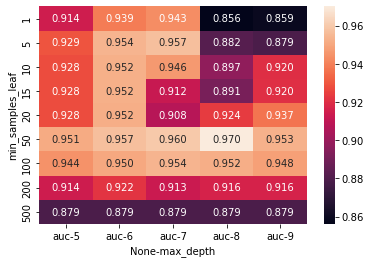

In [81]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

Right, this model has a better performance that a No Failure prediction with 97.00%, but it is not enough let's use an ensemble method, the Random Forest

### 4.5.- Random Forest

In [84]:
scores = []
for n in range(10, 501, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:,1]
    rf_auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, rf_auc))
    
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

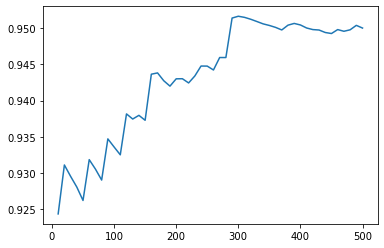

In [85]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [89]:
df_scores[df_scores.auc == df_scores.auc.max()]

,n_estimators,auc
29,300,0.95164


We have a best auc with 300 n_estimators, now let's move into the hyperparameters

### 4.5.1.- Random forest parameter tuning

In [92]:
scores = []

for d in [10, 15, 20]:
    for n in range(200, 601, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                   max_depth=d,
                                   random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        rf_auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, n, rf_auc))
        
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

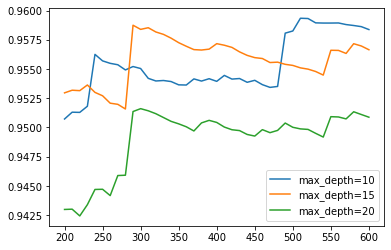

In [93]:
for d in [10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
            label='max_depth=%d' % d)

plt.legend()
plt.show()

It seems that the best max_depth is for 10 with 500 estimators

Now let's move it to the min_sample_leaf

In [94]:
max_depth = 10

In [107]:
scores = []

for s in [5, 10, 25, 50]:
    for n in range (1, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                   max_depth=max_depth,
                                   min_samples_leaf=s,
                                   random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        rf_auc = roc_auc_score(y_val, y_pred)
        
        scores.append((s, n, rf_auc))
        
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

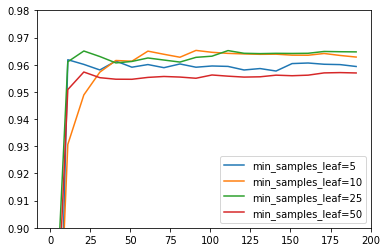

In [108]:
for s in [5, 10, 25, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
            label='min_samples_leaf=%s' % s)
plt.ylim(0.9,0.98)
plt.legend()
plt.show()

The best parameter is between 10 and 25, lets select 25.

In [110]:
min_samples_leaf = 25

In [111]:
rf = RandomForestClassifier(n_estimators=200,
                           max_depth=max_depth,
                           min_samples_leaf=min_samples_leaf,
                           random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=25, n_estimators=200,
                       random_state=1)

In [112]:
y_pred = rf.predict_proba(X_val)[:,1]
rf_auc = roc_auc_score(y_val, y_pred)
round(rf_auc*100, 2)

96.43

This is a little worst than a Decision Tree that we got 97%

Let's move to the last model which is XGBoost

### 4.6.- XGBoost

First let's create the train and val set

In [120]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

Now the watchlist and the parameters for the XGBoost model

In [123]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [128]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=50,
                  verbose_eval=2,
                  evals=watchlist)

The following def will help to threat the output of the XGBoost model

In [127]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

Now let's look at the best num_boost_round parameter

In [130]:
df_score = parse_xgb_output(output)

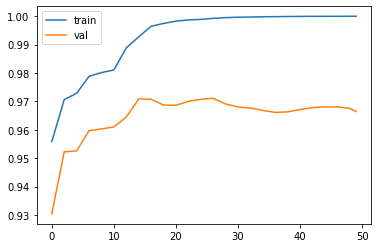

In [131]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [134]:
df_score[df_score.val_auc == df_score.val_auc.max()]

,num_iter,train_auc,val_auc
13,26,0.99925,0.9711


### 4.6.1.- First lets tune the eta

We will tune the model for eta = [0.01, 0.05, 0.1, 0.3, 1.0]

In [136]:
scores = {}

In [145]:
%%capture output

xgb_params = {
    'eta': 1.0,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval= 5,
                  evals=watchlist)

In [146]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [147]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.05', 'eta=0.1', 'eta=0.3', 'eta=1.0'])

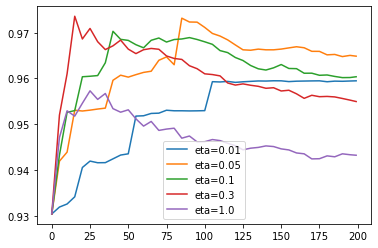

In [148]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

Let's choose eta=0.3 since it requires less boos rounds

### 4.6.2.- Tune the max_depth

Now let's vary max_depth = [3, 4, 6, 10]

In [174]:
scores = {}

In [181]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=300,
                  verbose_eval= 5,
                  evals=watchlist)

In [182]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

In [183]:
scores.keys()

dict_keys(['max_depth=3', 'max_depth=4', 'max_depth=6', 'max_depth=10'])

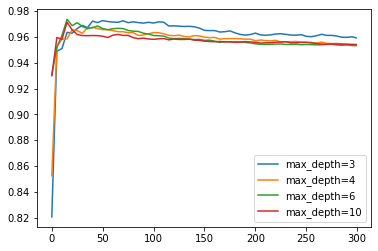

In [184]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()

Let's choose max_depth=3 since is higher than others in a higher interval

### 4.6.3.- Tune the min_child_weight

Now let's move into min_child_weight = [1, 10, 30]

In [185]:
scores = {}

In [190]:

%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval= 5,
                  evals=watchlist)

In [191]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

In [192]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

(0.9, 0.98)

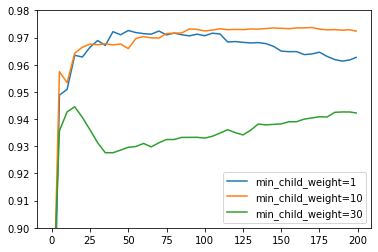

In [194]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.legend()
plt.ylim(0.9, 0.98)

Let's choose min_child_weight = 10 with num_boost_round=175

In [195]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 3,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [196]:
y_pred = model.predict(dval)

In [197]:
xgb_auc = roc_auc_score(y_val, y_pred)
round(xgb_auc*100, 2)

97.33

## 5.- Selecting the final model

Finally let's compare the four models and choose the best one.

### 5.1.- Linear Regression

In [198]:
lr = LogisticRegression(C=15)
lr.fit(X_train, y_train)

LogisticRegression(C=15)

In [199]:
y_pred = lr.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8896242252066117

### 5.2.- Decision Tree

In [200]:
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=50)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=50)

In [201]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9700816761363636

### 5.3.- Random Forest

In [203]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=25,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=25, n_estimators=200,
                       random_state=1)

In [204]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9642787964876033

### 5.4.- XGBoost

In [205]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 3,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [206]:
y_pred = model.predict(dval)

In [207]:
roc_auc_score(y_val, y_pred)

0.9732615573347108

So the best model that can be achieve is the XGBoost model with a 97.32%

## 6.- Model testing

Finally let's evaluate the auc in the test set using the full train set.

In [209]:
df_full_train = df_full_train.reset_index(drop=True)

In [210]:
y_full_train = df_full_train.target.values

In [211]:
del df_full_train['target']
del df_full_train['failure_type']

In [212]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [213]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train)
dtest = xgb.DMatrix(X_test)

In [214]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 3,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [215]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.9824697343446765